In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="css/custom.css">

# Demystifying pandas internals

## Marc Garcia - @datapythonista

## About me

<img style="float: left; margin-right: 20px" src="img/mgarcia.png"/>
**Marc Garcia**

* Pythonista since 2006
* Master degree in AI
* [Pandas contributor](https://github.com/pandas-dev/pandas/commits?author=datapythonista)
* Organiser of the [London Python Sprints](https://python-sprints.github.io/) group
* Contractor data scientist



More info at my [personal page](http://datapythonista.github.io/) and [LinkedIn profile](https://www.linkedin.com/in/datapythonista/)

Source code (jupyter notebook) of these slides:
- https://github.com/datapythonista/demystifying_pandas_internals

## Overview

- Quick pandas overview
- What can go wrong?
- Why pandas? Why not pure Python?
- Data types
- Computer architecture
- pandas internal structure
- Memory copy
- Future of pandas

## Quick pandas overview: Titanic

In [2]:
import pandas

titanic = pandas.read_csv('data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# basic statistics

titanic[['Age', 'Fare']].describe()

,Age,Fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200


In [4]:
# percentage of missing values

titanic[['Age', 'Fare']].isna().mean()

Age     0.198653
Fare    0.000000
dtype: float64

In [5]:
# imputing missing values with the median

titanic['Age'].fillna(titanic['Age'].median(), inplace=True)
titanic[['Age', 'Fare']].isna().mean()

Age     0.0
Fare    0.0
dtype: float64

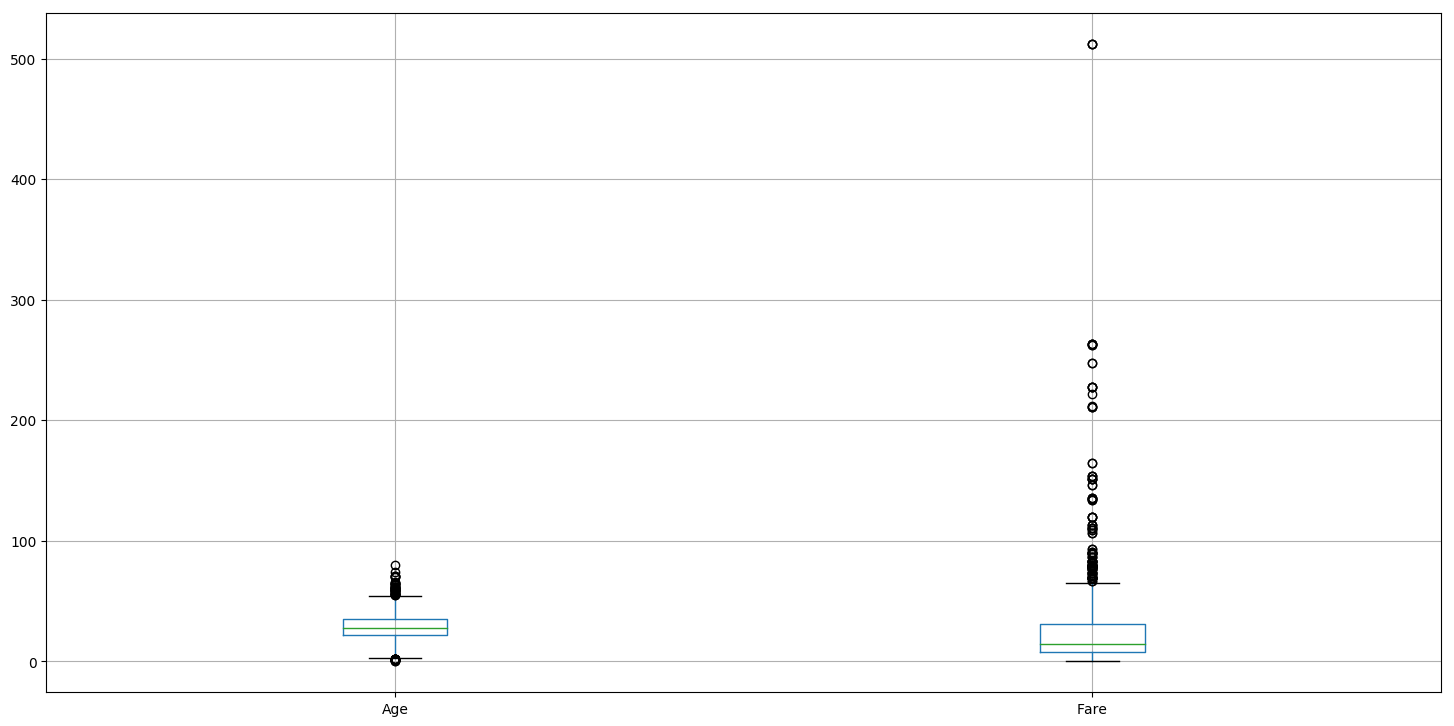

In [6]:
# plot distributions

titanic[['Age', 'Fare']].boxplot();

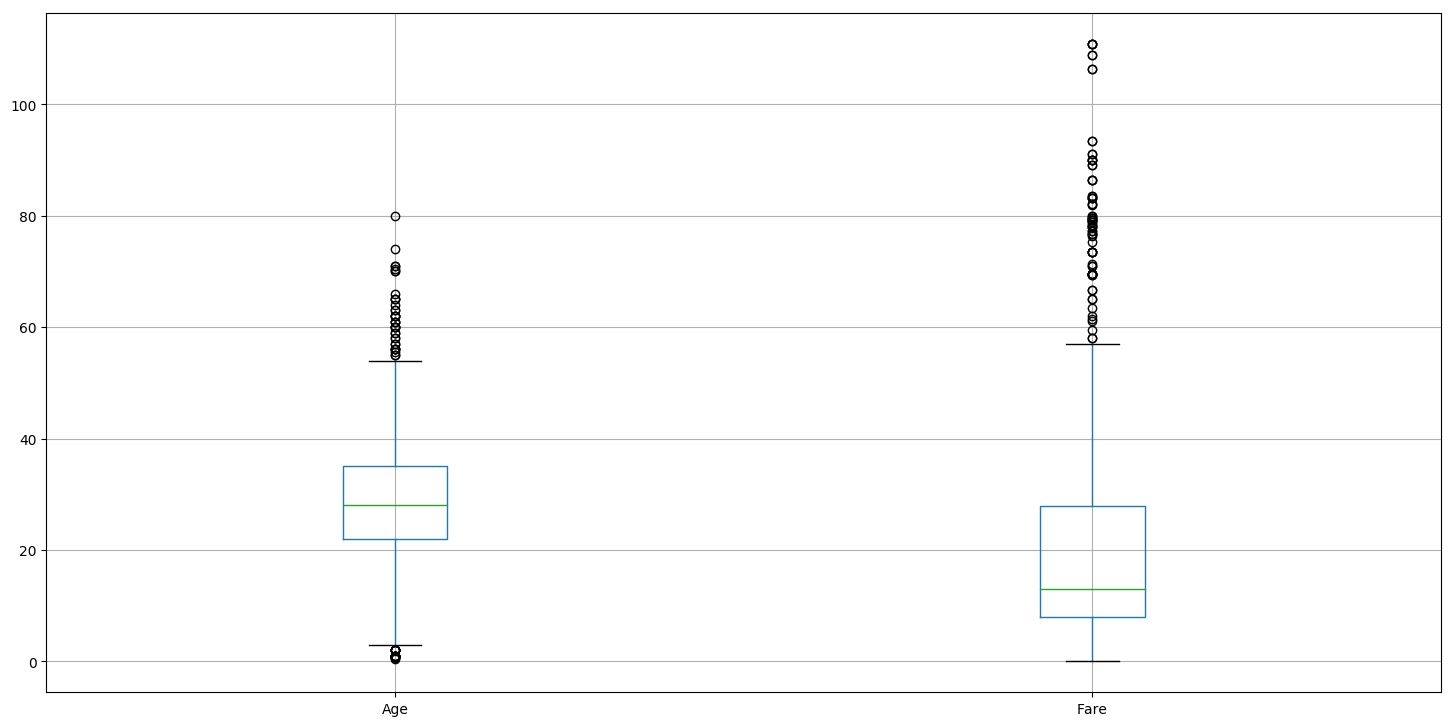

In [7]:
# dropping rows with 5% higher fares

titanic = titanic[titanic['Fare'] < titanic['Fare'].quantile(.95)]
titanic[['Age', 'Fare']].boxplot();

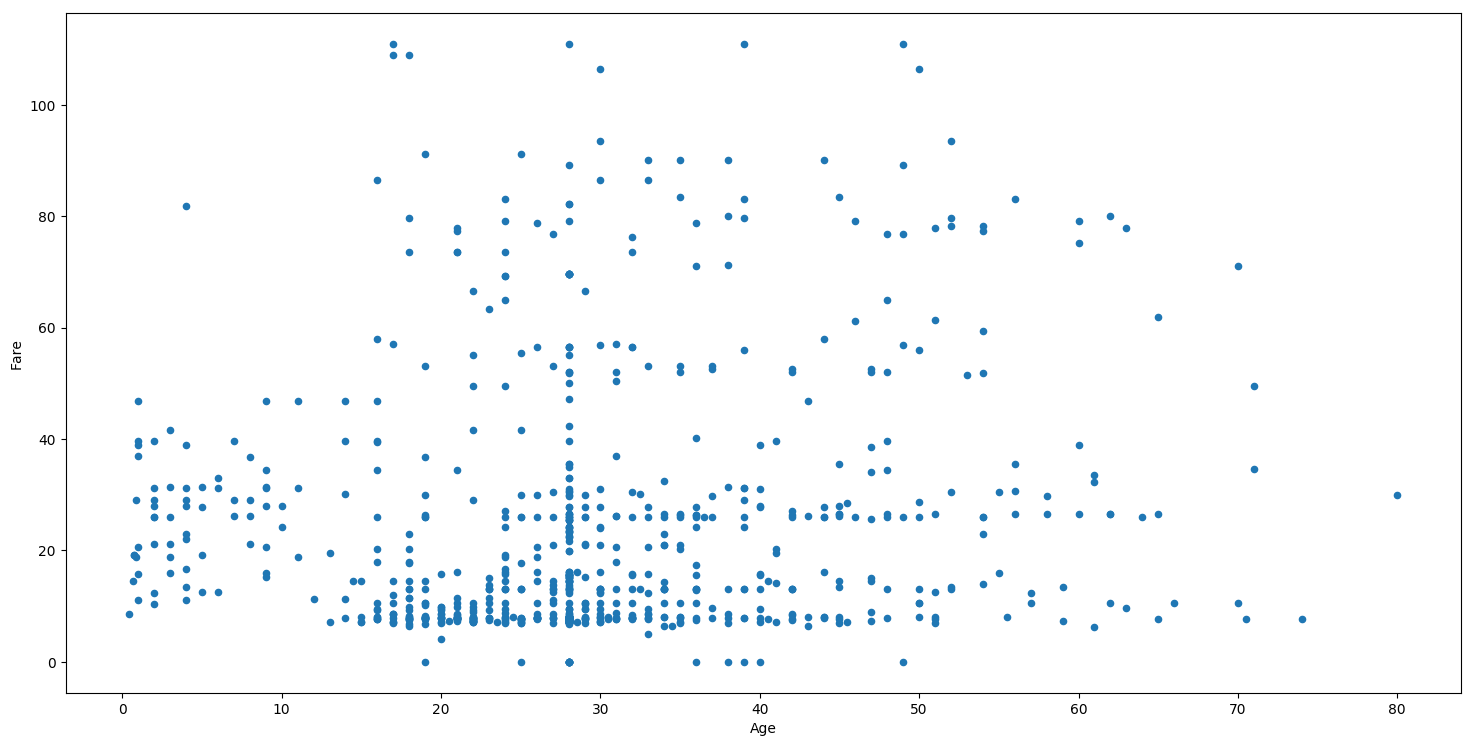

In [8]:
# plotting correlation

titanic.plot(kind='scatter', x='Age', y='Fare');

In [9]:
# compute correlation

titanic[['Age', 'Fare']].corr()

,Age,Fare
Age,1.000000,0.145508
Fare,0.145508,1.000000


In [10]:
# get dummies for categories

dummies = pandas.get_dummies(titanic[['Sex', 'Embarked']])
dummies.head()

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,0,1
1,1,0,1,0,0
2,1,0,0,0,1
3,1,0,0,0,1
4,0,1,0,0,1


In [11]:
# prepare data for machine learning models

x = titanic[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].join(dummies)
y = titanic['Survived']
x.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


In [12]:
import sklearn.ensemble

clf = sklearn.ensemble.RandomForestClassifier()
clf.fit(x, y)
pandas.Series(clf.feature_importances_, index=x.columns).sort_values(ascending=False)

Age           0.266413
Fare          0.251490
Sex_male      0.226070
Pclass        0.087555
SibSp         0.056010
Sex_female    0.050103
Parch         0.033255
Embarked_S    0.014759
Embarked_Q    0.007314
Embarked_C    0.007031
dtype: float64

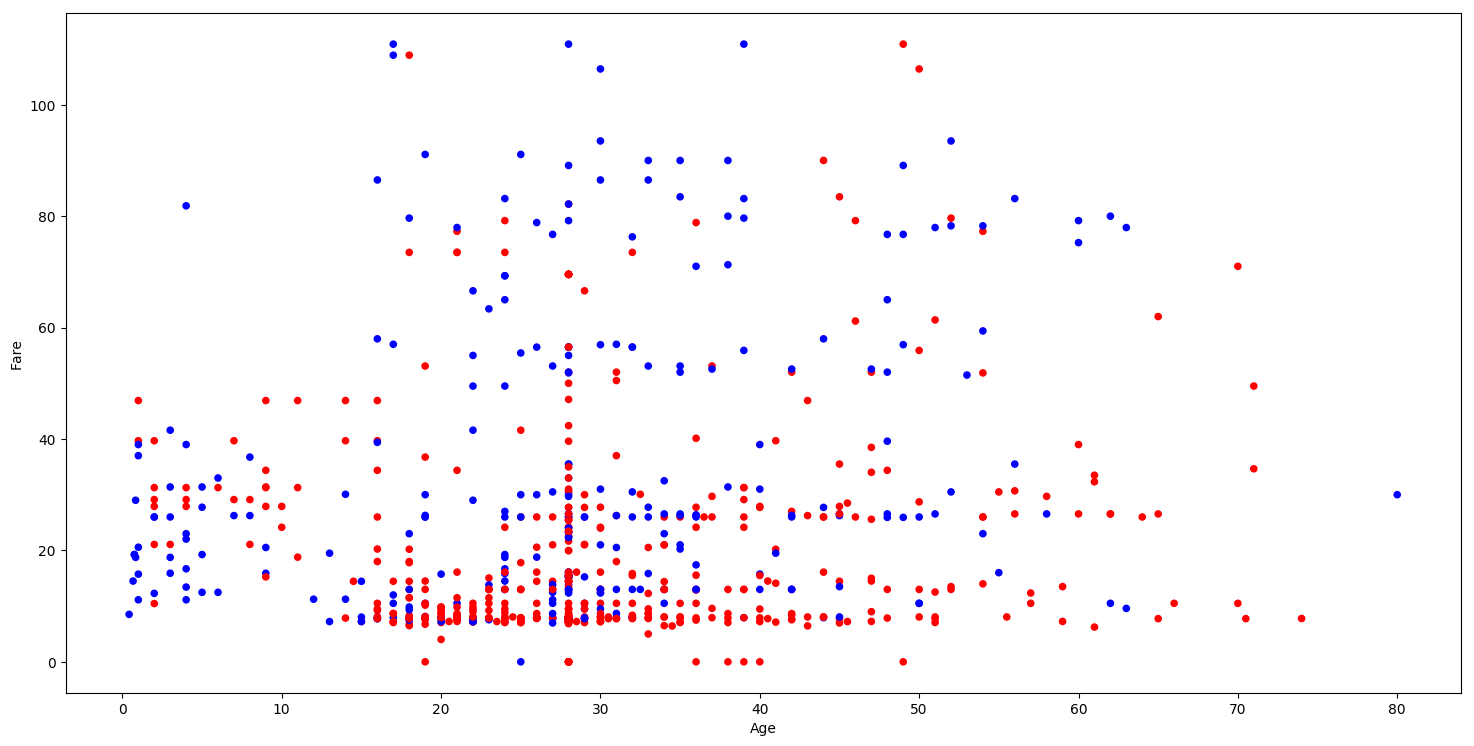

In [13]:
titanic.plot(kind='scatter', x='Age', y='Fare', color=y.replace({0: 'red', 1: 'blue'}));

## This is pandas, and it is super cool

![](img/cool_pandas.jpg)

## What can go wrong?

And why should be care about how pandas works **internally**?

In [14]:
# some code resembling pandas to make the traceback look nice
import numpy

cols_from_csv = rows_from_csv = lambda fname: 10_000_000

def read_csv(fname, *args, **kwargs):
    cols = cols_from_csv(fname)
    rows = rows_from_csv(fname)
    create_block_manager_from_arrays(rows, cols)

def create_block_manager_from_arrays(rows, cols):
    float_blocks = _multi_blockify((rows, cols), numpy.float64)

def _multi_blockify(shape, dtype):
    _stack_arrays(shape, dtype)

def _stack_arrays(shape, dtype):
    stacked = numpy.empty(shape, dtype)

original_read_csv = pandas.read_csv
pandas.read_csv = read_csv

In [15]:
import pandas

df = pandas.read_csv('data/huge_file.csv')

MemoryError: 

In [16]:
pandas.read_csv = original_read_csv

In [17]:
original_read_csv = pandas.read_csv

class DataFrame:
    def __init__(self, *args, **kwargs):
        pass

    @staticmethod
    def sum():
        import IPython.display
        img = IPython.display.Image(filename='img/waiting.jpg')
        IPython.display.display(img)

pandas.read_csv = DataFrame

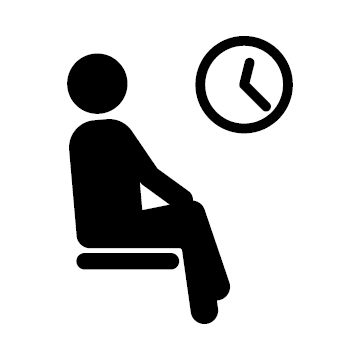

In [18]:
import pandas

df = pandas.read_csv('data/huge_file.csv')
total = df.sum()

In [19]:
pandas.read_csv = original_read_csv

In [20]:
import pandas

titanic = pandas.read_csv('data/titanic.csv')
titanic_male = titanic[titanic['Sex'] == 'male']
titanic_male['Age'].fillna(titanic_male['Age'].median(), inplace=True)

/home/mgarcia/.anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [21]:
import warnings
import pandas

warnings.filterwarnings('ignore')

titanic = pandas.read_csv('data/titanic.csv')
titanic_male = titanic[titanic['Sex'] == 'male']
titanic_male['Age'].fillna(titanic_male['Age'].median(), inplace=True)

![](img/disaster_girl.jpg)

## ...you know you did something wrong

## Why pandas? Why not pure Python?

In [22]:
# pandas.read_csv('data/titanic.csv')
import csv

data = []
with open('data/titanic.csv') as f:
    reader = csv.reader(f)
    columns = next(reader)
    for row in reader:
        data.append(row)

In [23]:
columns = ('Name', 'Sex', 'Age', 'Fare', 'Survived')

data = [('Montvila, Rev. Juozas',                    'male',     27.,    13., 0),
        ('Graham, Miss. Margaret Edith',             'female',   19.,    30., 1),
        ('Johnston, Miss. Catherine Helen "Carrie"', 'female',  None,  23.45, 0),
        ('Behr, Mr. Karl Howell',                    'male',     26.,    30., 1),
        ('Dooley, Mr. Patrick',                      'male',     32.,   7.75, 0)]

In [24]:
# df.iloc[3]
data[3]

('Behr, Mr. Karl Howell', 'male', 26.0, 30.0, 1)

In [25]:
# df['Fare']
fares = list(zip(*data))[columns.index('Fare')]
fares

(13.0, 30.0, 23.45, 30.0, 7.75)

In [26]:
# df['Fare'].mean()
mean_fare = sum(fares) / len(fares)
mean_fare

20.84

In [27]:
# df[df.Sex == 'male']
male = list(filter(lambda x: x[columns.index('Sex')] == 'male', data))
male

[('Montvila, Rev. Juozas', 'male', 27.0, 13.0, 0),
 ('Behr, Mr. Karl Howell', 'male', 26.0, 30.0, 1),
 ('Dooley, Mr. Patrick', 'male', 32.0, 7.75, 0)]

## Why pandas? Why not pure Python?

- Easy and powerful indexing
- Management of missing values
- High-level functionality:
 - Statistics
 - Time series
 - Groupping
 - ...

- **Performance**

## Some computer engineering background

- Data types
- Computer architecture

## Data types

unsigned integer 4 bits:

Binary | Decimal | | Binary | Decimal |
-------|---------|-|--------|---------|
0000   |      0  | | 1000   |      8  |
0001   |      1  | | 1001   |      9  |
0010   |      2  | | 1010   |     10  |
0011   |      3  | | 1011   |     11  |
0100   |      4  | | 1100   |     12  |
0101   |      5  | | 1101   |     13  |
0110   |      6  | | 1110   |     14  |
0111   |      7  | | 1111   |     15  |

## Data types

signed integer 4 bits (two's complement):

Binary | Decimal | | Binary | Decimal |
-------|---------|-|--------|---------|
0000   |      0  | | 1000   |     -8  |
0001   |      1  | | 1001   |     -7  |
0010   |      2  | | 1010   |     -6  |
0011   |      3  | | 1011   |     -5  |
0100   |      4  | | 1100   |     -4  |
0101   |      5  | | 1101   |     -3  |
0110   |      6  | | 1110   |     -2  |
0111   |      7  | | 1111   |     -1  |

## Data types

Decimal numbers:
 - Precision
 - Exponent

$value = precision \cdot 2^{exponent}$

$1328.543 = 1.328543 \cdot 10^{3}$

## Data types

floating point 4 bits (2 bits exponent, 2 bits precision):

Binary  | Exponent | Precision | Decimal | | Binary  | Exponent | Precision | Decimal |
--------|----------|-----------|---------|-|---------|----------|-----------|---------|
00-00   |       0  |     1.00  |   1.00  | | 10-00   |      -2  |    1.00   |  0.010  |
00-01   |       0  |     1.50  |   1.50  | | 10-01   |      -2  |    1.50   |  0.015  |
00-10   |       0  |     1.25  |   1.25  | | 10-10   |      -2  |    1.25   |  0.013  |
00-11   |       0  |     1.75  |   1.75  | | 10-11   |      -2  |    1.75   |  0.018  |
01-00   |       1  |        0  |   +INF  | | 11-00   |      -1  |    1.00   |  0.100  |
01-01   |       1  |        1  |      0  | | 11-01   |      -1  |    1.50   |  0.150  |
01-10   |       1  |        2  |    NaN  | | 11-10   |      -1  |    1.25   |  0.125  |
01-11   |       1  |        3  |   -INF  | | 11-11   |      -1  |    1.75   |  0.175  |

Not all numbers can be represented

In [28]:
0.1 + 0.2

0.30000000000000004

In [29]:
import numpy

numpy.array([256], dtype=numpy.uint8)

array([0], dtype=uint8)

Special numbers exist in floating point but not integer representation: `inf`, `-inf`, `NaN`

In [30]:
import pandas

s = pandas.Series([1, 2])
print(s)

0    1
1    2
dtype: int64


In [31]:
s.loc[0] = float('NaN')
print(s)

0    NaN
1    2.0
dtype: float64


### Example 1: Comparing list items, int vs float

In [55]:
import random

size = 10_000_000

list1 = [random.random() for i in range(size)]
list2 = [random.random() for i in range(size)]

In [56]:
import numpy
import pandas

series1 = pandas.Series(list1, dtype=numpy.uint8)
series2 = pandas.Series(list2, dtype=numpy.uint8)

print('Memory consumed: {:.2f} Mb'.format(series1.memory_usage(index=False) / 1024 / 1024))

%timeit (series1 > series2).mean()

Memory consumed: 9.54 Mb
16.6 ms ± 343 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
import numpy
import pandas

series1 = pandas.Series(list1, dtype=numpy.float64)
series2 = pandas.Series(list2, dtype=numpy.float64)

print('Memory consumed: {:.2f} Mb'.format(series1.memory_usage(index=False) / 1024 / 1024))

%timeit (series1 > series2).mean()

Memory consumed: 76.29 Mb
72.1 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Computer architecture

![](img/inside_computer.jpg)

![](img/books.png)

![](img/memory_hierarchy.png)

![](img/cpu_memory_speed.jpg)

![](img/cpu_add.png)

### Machine code

Address | Binary   | Decimal (uint8) |
--------|----------|-----------------|
0320    | 00001111 |             25  |
0321    | 00001010 |             41  |
0322    | 00000010 |              2  |

```
1) LOAD 0320 -> R1   (R1=25, R2= ?)
2) LOAD 0321 -> R2   (R1=25, R2=41)
3) ADD R1 R2 -> R2   (R1=25, R2=66)
4) LOAD 0322 -> R1   (R1= 2, R2=66)
5) ADD R1 R2 -> R2   (R1= 2, R2=68)
```

### Machine code

```
1) LOAD 0320 -> R1   (R1=25, R2= ?)
2) LOAD 0321 -> R2   (R1=25, R2=41)  <- Preload to the CPU cache at 1)
3) ADD R1 R2 -> R2   (R1=25, R2=66)
4) LOAD 0322 -> R1   (R1= 2, R2=66)  <- Preload to the CPU cache at 1)
5) ADD R1 R2 -> R2   (R1= 2, R2=68)
```

Loading from the memory is slow:
- **CPU cache**

### Example 2: Summing list elements

In [36]:
import random
import functools
import operator

size = 10_000_000
list1 = [random.random() for i in range(size)]

%timeit functools.reduce(operator.add, list1)

886 ms ± 143 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
import pandas

s1 = pandas.Series(list1)

%timeit s1.sum()

80.2 ms ± 9.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Example 3: Comparing list items, Python vs pandas

![](img/cpu_cmp.png)

In [38]:
%timeit sum(item1 > item2 for item1, item2 in zip(list1, list2)) / size

1.64 s ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
import pandas

series1 = pandas.Series(list1)
series2 = pandas.Series(list2)

%timeit (series1 > series2).mean()

71.1 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


**numpy** and **pandas** implementation are somehow similar to the machine code we've seen.

### What about the pure Python implementation?

Python is implemented with great ideas in mind:
- Readability
- Flexibility
- Hassle free
- No need to care about types

But not fast numerical computations

In [40]:
data = [1, 'foo', 3.141592, ['Alan', 'Dennis', 'Linus'],
        {'black': '#000000', 'white': '#ffffff'}]
data

[1,
 'foo',
 3.141592,
 ['Alan', 'Dennis', 'Linus'],
 {'black': '#000000', 'white': '#ffffff'}]

![](img/pyobject_list.jpg)

Address | PyObject                                                         |
--------|------------------------------------------------------------------|
0320    | ob_refcnt=1, ob_type=list, ob_size=3, ob_item=0510, allocated=16 |
 ...    | ...                                                              |
0510    |                                                           2478   |
0511    |                                                           5601   |
0512    |                                                           4882   |
 ...    | ...                                                              |
2478    | ob_refcnt=1, ob_type=int, ob_value=15                            |
 ...    | ...                                                              |
4882    | ob_refcnt=1, ob_type=int, ob_value=2                             |
 ...    | ...                                                              |
5601    | ob_refcnt=1, ob_type=int, ob_value=10                            |

```
1) LOAD 0320
2) LOAD 0510
3) LOAD 2478 (ob_value) -> R1
4) LOAD 0511
5) LOAD 5601 (ob_value) -> R2
6) ADD R1 R2 -> R2
...
```

compare to:

```
1) LOAD 0320 -> R1   (R1=15, R2= ?)
2) LOAD 0321 -> R2   (R1=15, R2=10)
3) ADD R1 R2 -> R2   (R1=15, R2=25)
```

In [41]:
import pandas

pandas.Series(data)

0                                           1
1                                         foo
2                                     3.14159
3                       [Alan, Dennis, Linus]
4    {'black': '#000000', 'white': '#ffffff'}
dtype: object

In [42]:
import pandas

series1 = pandas.Series(list1, dtype='object')
series2 = pandas.Series(list2, dtype='object')

%timeit (series1 > series2).mean()

868 ms ± 117 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
import numpy
import pandas

series1 = pandas.Series(list1, dtype=numpy.float64)
series2 = pandas.Series(list2, dtype=numpy.float64)

%timeit (series1 > series2).mean()

77.2 ms ± 4.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Pandas internal structure

In [44]:
import pandas

df = pandas.DataFrame({'foo': [1, 3, 7],
                       'bar': [.55, 1.76, 3.33],
                       'foobar': [109, 60, 13]},
                      columns=['foo', 'bar', 'foobar'])
print(df.dtypes)
df

foo         int64
bar       float64
foobar      int64
dtype: object


,foo,bar,foobar
0,1,0.55,109
1,3,1.76,60
2,7,3.33,13


In [45]:
df._data

BlockManager
Items: Index(['foo', 'bar', 'foobar'], dtype='object')
Axis 1: RangeIndex(start=0, stop=3, step=1)
FloatBlock: slice(1, 2, 1), 1 x 3, dtype: float64
IntBlock: slice(0, 4, 2), 2 x 3, dtype: int64

In [46]:
df._data.blocks

(FloatBlock: slice(1, 2, 1), 1 x 3, dtype: float64,
 IntBlock: slice(0, 4, 2), 2 x 3, dtype: int64)

In [47]:
df._data.blocks[1].values

array([[  1,   3,   7],
       [109,  60,  13]])

In [48]:
type(df._data.blocks[1].values)

numpy.ndarray

In [49]:
df._data.blocks[1].values.data

In [50]:
df._data.blocks[1].values.nbytes

48

In [51]:
bytes_ = df._data.blocks[1].values.tobytes()

print(''.join('{:08b}'.format(byte) for byte in bytes_))

000000010000000000000000000000000000000000000000000000000000000000000011000000000000000000000000000000000000000000000000000000000000011100000000000000000000000000000000000000000000000000000000011011010000000000000000000000000000000000000000000000000000000000111100000000000000000000000000000000000000000000000000000000000000110100000000000000000000000000000000000000000000000000000000


In [52]:
df._data.blocks[1].values.strides

(24, 8)

![](img/block_manager.png)

Source: https://www.dataquest.io/blog/pandas-big-data/

In [53]:
import numpy

data = numpy.empty((1000, 1000), numpy.float64)

%timeit data.sum(axis=0)
%timeit data.sum(axis=1)

799 µs ± 83.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
721 µs ± 79.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Memory copy

- Read/write to memory is slow
- When a operation (e.g. a filter) is performed, a **copy** or a **view** can be returned
 - pandas **returns** a view in few cases, but **is not deterministic**

In [54]:
import pandas

df = pandas.DataFrame({'foo': [1, 2, 3], 'bar': [5, 10, 15]})

df_view_or_copy = df[df.foo > 2]

df_view_or_copy['bar'] = 0  # are we modifying `df`? <- Chained indexing with unknown result: WARNING

df[df.foo > 2]['bar'] = 0  # same as before

df.loc[df.foo > 2, 'bar'] = 0  # we are modifying `df` (pandas manages __setitem__)

## Future of pandas

- **BlockManager** is tricky, get rid of it
- Refactoring of **types**
- numpy is a great backend in some cases, but add support for others too (e.g. **Apache Arrow**)
- More consistency in **missing values** (add bitmaps to manage `NaN`s in any type
- Native support of **strings**, not as `object`
- Better management of **memory**
- pandas in **distributed systems** (Dask, PySpark, Ibis...)

Join the **pandas sprint** tomorrow... :)

## Random take aways

Pandas is really amazing

Use parquet, pickle... instead of csv when possible

Access to memory is key for performance

Data types are important (implications in memory, speed and possible values)

Avoid `object` dtype, and loops (PyObject) for optimal performance

## Thank you

You can find me on the internet: **@datapythonista**

![](img/pandas_tired.jpg)

## References

Articles:
- Why Python is slow https://jakevdp.github.io/blog/2014/05/09/why-python-is-slow/
- pandas2 design documents https://pandas-dev.github.io/pandas2/index.html
- View vs copy https://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
- Rules for view vs copy https://stackoverflow.com/questions/23296282/what-rules-does-pandas-use-to-generate-a-view-vs-a-copy

Talks:
- Jeff Reback - The future of pandas https://www.youtube.com/watch?v=_-gJtO0XR48
- Francesc Alted - Squeeze (gently) your data https://www.youtube.com/watch?v=o9PC4JC74tU
- Wes McKinney - Python data wrangling https://www.youtube.com/watch?v=BDhjOUPQLUc

Floating point notation:
- https://www.johndcook.com/blog/2009/07/21/ieee-arithmetic-python/
- https://docs.python.org/3.6/tutorial/floatingpoint.html
- http://www.lahey.com/float.htm
- https://en.wikipedia.org/wiki/IEEE_754